In [1]:
from dotenv import load_dotenv

load_dotenv()

True

왠지는 모르겠지만 upstage 로는 잘 안됐음...

```python
from langchain_upstage import ChatUpstage

llm = ChatUpstage(model='solar-pro2')

small_llm = ChatUpstage(model='solar-mini')

```

In [16]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

small_llm = ChatOpenAI(model='gpt-4o-mini')


In [3]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [4]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply]
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [5]:
ai_message = llm_with_tools.invoke('What is 3 plus 5?')
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kiqj0o9HXDCD1MnQD768DFGe', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 84, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-COyIXJkmJFe1lZWipNK3KOkMsgBEN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8f3d0933-0e76-448d-bd59-5f34cae47abb-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_kiqj0o9HXDCD1MnQD768DFGe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 84, 'output_tokens': 17, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read':

In [6]:
tool_node.invoke({'messages': [ai_message]})

{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_kiqj0o9HXDCD1MnQD768DFGe')]}

In [7]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [8]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']

    # LLM과 도구를 사용하여 메시지를 처리하고 응답을 생성합니다.
    response = llm_with_tools.invoke(messages)

    # 응답 메시지를 새로운 상태로 반환합니다.
    return {'messages': [response]}

In [9]:
from typing import Literal
from langgraph.graph import END

def should_continue(state: MessagesState) -> Literal['tools', END]:
    """
    주어진 메시지 상태를 기반으로 에이전트가 계속 진행할지 여부를 결정합니다.

    Args:
        state (MessagesState): `state`를 포함하는 객체.

    Returns:
        Literal['tools', END]: 도구를 사용해야 하면 `tools`를 리턴하고,
        답변할 준비가 되었다면 END를 반환해서 프로세스를 종료합니다.
    """
    # 상태에서 메시지를 추출합니다.
    messages = state['messages']

    # 마지막 AI 메시지를 가져옵니다.
    last_ai_message = messages[-1]

    # 마지막 AI 메시지가 도구 호출을 포함하고 있는지 확인합니다.
    if last_ai_message.tool_calls:
        # 도구 호출이 있으면 'tools'를 반환합니다.
        return 'tools'

    # 도구 호출이 없으면 END를 반환하여 프로세스를 종료합니다.
    return END

In [10]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

In [12]:
graph= graph_builder.compile()

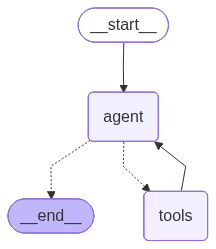

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  add (call_HXRXdgT66iaZ7cBKMPvRIwck)
 Call ID: call_HXRXdgT66iaZ7cBKMPvRIwck
  Args:
    a: 3
    b: 5
  multiply (call_e6gBrN3W4MaeuPn0zC7jtwnx)
 Call ID: call_e6gBrN3W4MaeuPn0zC7jtwnx
  Args:
    a: 5
    b: 8
================================= Tool Message =================================
Name: multiply

40
================================== Ai Message ==================================

3에 5를 더하면 8이고, 그 8에 5를 곱하면 40입니다. 

따라서, 3에 5를 더하고 그 결과에 8을 곱하면 40이 됩니다.
